In [ ]:
"""Author: Melwyn D Souza, Reg No: R00209495"""

import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
from keras.models import load_model
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
!cd "gdrive/My Drive/A2"
!ls

Mounted at /content/gdrive
gdrive	sample_data


In [ ]:
#copied over from assigment pdf appendix
def loadDataH5():  
    with h5py.File('gdrive/My Drive/A2/earth_data.h5','r') as hf:
        trainX = np.array(hf.get('trainX'))
        trainY = np.array(hf.get('trainY'))
        valX = np.array(hf.get('valX'))
        valY = np.array(hf.get('valY'))
        # print (trainX.shape,trainY.shape)
        # print (valX.shape,valY.shape)
    return trainX, trainY, valX, valY

In [ ]:
def dataGennerator(images,labels):
      
    trainDataGen = ImageDataGenerator(shear_range=0.1,
                                      zoom_range=0.1,
                                      rotation_range=20,
                                      horizontal_flip=True, 
                                      width_shift_range=0.1,
                                      height_shift_range=0.1,
                                      fill_mode = 'reflect')
                                                                    
    trainGen = trainDataGen.flow(images, labels, batch_size = 32)
    
    return trainGen

In [ ]:
def vgg1():
  vggModel = tf.keras.applications.VGG16(weights='imagenet', include_top = False, input_shape = (64,64,3))
  vggModel.trainable = False
  # print(vggModel.summary())
  model = tf.keras.models.Sequential()
  model.add(vggModel)
  model.add(Flatten())
  model.add(Dropout(0.1))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(9, activation=tf.nn.softmax))

  return model


In [ ]:
def vgg2():
  vggModel = tf.keras.applications.VGG16(weights='imagenet', include_top = False, input_shape = (64,64,3))
  vggModel.trainable = True

  trainableFlag = False
  for layer in vggModel.layers:
    if layer.name == "block5_conv1":
      trainableFlag = True
    layer.trainable = trainableFlag
  
  model = tf.keras.models.Sequential()
  model.add(vggModel)
  model.add(Flatten())
  model.add(Dropout(0.1))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(9, activation=tf.nn.softmax))

  return model

In [ ]:
def vgg3():
  vggModel = tf.keras.applications.VGG16(weights='imagenet', include_top = False, input_shape = (64,64,3))
  vggModel.trainable = True

  trainableFlag = False
  for layer in vggModel.layers:
    if layer.name == "block4_conv1":
      trainableFlag = True
    layer.trainable = trainableFlag

  model = tf.keras.models.Sequential()
  model.add(vggModel)
  model.add(Flatten())
  model.add(Dropout(0.1))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(9, activation=tf.nn.softmax))
  
  return model

In [ ]:
def vgg4():
  vggModel = tf.keras.applications.VGG16(weights='imagenet', include_top = False, input_shape = (64,64,3))
  vggModel.trainable = True
  layers = ['block3_conv1','block4_conv1', 'block5_conv1']

  trainableFlag = False
  for layer in vggModel.layers:
    if layer.name in layers:
      layer.trainable = True
    else:
      layer.trainable = False

  model = tf.keras.models.Sequential()
  model.add(vggModel)
  model.add(Flatten())
  model.add(Dropout(0.1))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(9, activation=tf.nn.softmax))
  
  return model

MODEL 0 TRAINING
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dense_3 (Dense)             (None, 9)                 2313      
                                                                 
Total params: 15,241,545
Trainable params: 4,361,993
Non-trainable params: 10,879,552
_________________________________________________________________
None
Epoch 1/50
2

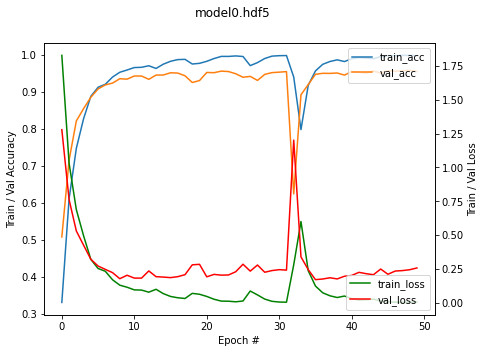

In [ ]:
def main():
  
  dataAug = False
  tr_x, tr_y, val_x, val_y = loadDataH5()
  tr_x, val_x = tr_x/255, val_x/255 #Normalize data
  epocs = 50 #epochs 
  batchsize = 32

  # mainmodels = [vgg4()]
  mainmodels = [vgg1(), vgg2(), vgg3(), vgg4()]
  modelnames = []

  for i in range(len(mainmodels)):
    print("MODEL {} TRAINING".format(i))
    model = mainmodels[i]
    
    print(model.summary())

    fname = 'weights.hdf5'
    # os.path.isfile(fname)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(fname, monitor='val_loss',
                                                    mode='min', save_best_only=True, verbose=1)
    if i>=1:
      print("Setting learning rate to (lr=1e-5) when optimizing VGG weights")
      model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    else:
      model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

    if dataAug == True:
      print("Data Augmenting")
      augmentedData = dataGennerator(tr_x, tr_y)  
      history = model.fit(augmentedData, epochs=epocs, validation_data=(val_x, val_y), steps_per_epoch = 20, callbacks = [checkpoint])
    else:
      history = model.fit(tr_x, tr_y, epochs=epocs,  validation_data=(val_x, val_y), steps_per_epoch = 20, callbacks = [checkpoint])
    
    saveName = 'model'+str(i)+'.hdf5'
    fig = plt.figure(figsize=(7,5))
    fig.suptitle(saveName)
    ax1 = fig.add_subplot()
    ax2 = ax1.twinx()
  
    ax2.plot(np.arange(0, epocs), history.history["loss"], color='green', label="train_loss")
    ax2.plot(np.arange(0, epocs), history.history["val_loss"], color='red', label="val_loss")
    ax1.plot(np.arange(0, epocs), history.history["accuracy"], label="train_acc")
    ax1.plot(np.arange(0, epocs), history.history["val_accuracy"], label="val_acc")
    ax1.set_ylabel("Train / Val Accuracy")
    ax2.set_ylabel("Train / Val Loss")
    ax1.set_xlabel("Epoch #")
    ax1.legend(loc ='upper right')
    ax2.legend(loc= 'lower right')
    plt.show()

main()